In [5]:
import sys

sys.path.append("/workspace/circuit-finder")

import torch

from functools import partial
from circuit_finder.data_loader import load_datasets_from_json
from circuit_finder.pretrained import load_model
from circuit_finder.experiments.run_dataset_sweep import ALL_DATASETS
from circuit_finder.metrics import batch_avg_answer_diff, batch_avg_answer_val
from circuit_finder.constants import ProjectDir

torch.set_grad_enabled(False)

model = load_model()


def logit_diff(model, tokens, batch):
    # Get the last-token logits
    logits = model(tokens)[:, -1, :]
    logit_diff = batch_avg_answer_diff(logits, batch)
    return logit_diff.mean()


def correct_answer_prob(model, tokens, batch):
    # Get the last-token logits
    logits = model(tokens)[:, -1, :]
    probs = torch.softmax(logits, dim=-1)
    answer_prob = batch_avg_answer_val(probs, batch)
    return answer_prob.mean()

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [6]:
import pandas as pd 
import pathlib

rows = []

for dataset_path in ALL_DATASETS:
    train_loader, _ = load_datasets_from_json(
        model, ProjectDir / dataset_path, torch.device("cuda"),
        batch_size = 32
    )
    batch = next(iter(train_loader))
    metric_fn = partial(logit_diff, batch=batch)
    prob_fn = partial(correct_answer_prob, batch=batch)
    clean_metric = metric_fn(model, batch.clean)
    corrupt_metric = metric_fn(model, batch.corrupt)
    correct_prob = prob_fn(model, batch.clean)

    rows.append({
        "dataset": pathlib.Path(dataset_path).stem,
        "clean": clean_metric.item(),
        "corrupt": corrupt_metric.item(),
        "correct_prob": correct_prob.item()
    })

df = pd.DataFrame(rows)
df.head()


,dataset,clean,corrupt,correct_prob
0,animal_diet_long_prompts,3.896435,1.327130,0.047630
1,animal_diet_short_prompts,2.215019,-0.180964,0.004275
2,docstring_prompts,4.432165,-1.160735,0.193433
3,gender_bias,0.987575,-3.123441,0.255011
4,greaterthan_gpt2-small_prompts,4.438992,-1.391720,0.068084


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

<Axes: xlabel='correct_prob', ylabel='dataset'>

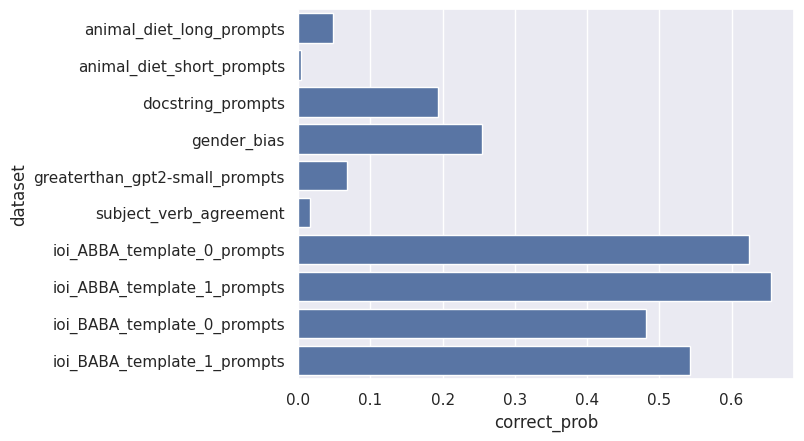

In [9]:
sns.barplot(data=df, y="dataset", x="correct_prob")

Text(0.5, 1.0, 'Clean vs corrupt metrics for all datasets, batch_size = 32')

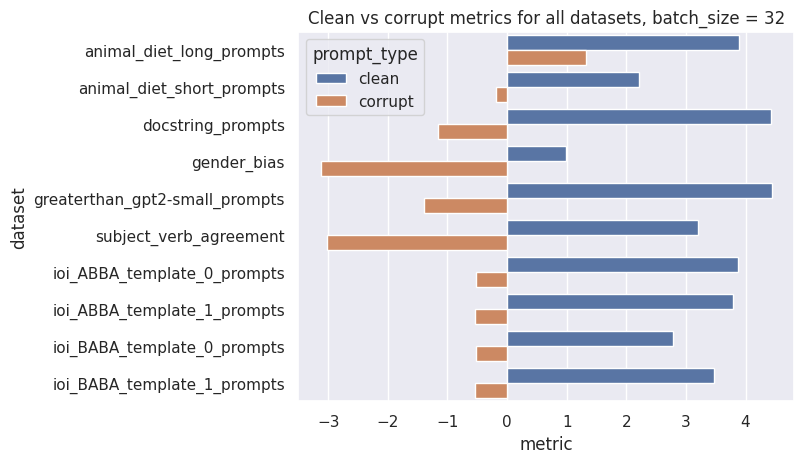

In [7]:

plot_df = pd.melt(df, id_vars="dataset", value_vars=["clean", "corrupt"]).rename(columns={"variable": "prompt_type", "value": "metric"})
sns.barplot(data=plot_df, y="dataset", x="metric", hue="prompt_type")
plt.title(f"Clean vs corrupt metrics for all datasets, batch_size = {32}")

Text(0.5, 1.0, 'Correct probability vs elicitation for all datasets, batch_size = 32')

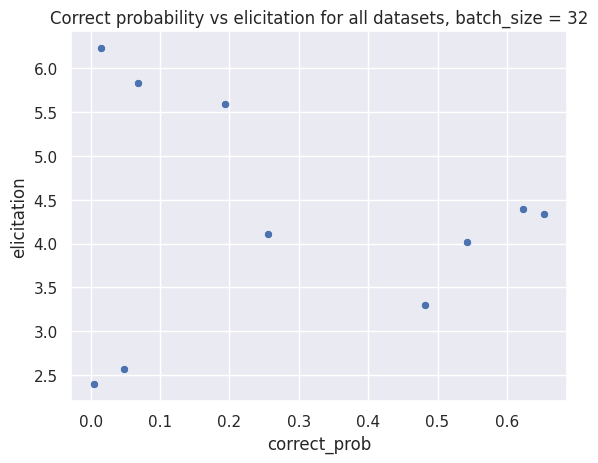

In [13]:
df['elicitation'] = df['clean'] - df['corrupt']
sns.scatterplot(data=df, x="correct_prob", y="elicitation")
plt.title("Correct probability vs elicitation for all datasets, batch_size = 32")